In [1]:
# !pip install --pre torch==1.7.0.dev20200701+cu101 torchvision==0.8.0.dev20200701+cu101 -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

In [2]:
DEBUG = False

In [3]:
# pip install timm

In [4]:
# !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [5]:
import os
import sys
# sys.path = [
#     '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',
# ] + sys.path

In [6]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.cuda.amp import GradScaler
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
import timm
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm
from torch.cuda.amp import GradScaler

# Config

In [7]:
data_dir = './data'
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')

kernel_type = 'ese_vovnet19b_dw_fold0of5'

#enet_type = 'efficientnet-b0'
fold = 1
tile_size = 256
image_size = 256
n_tiles = 34
batch_size = 6
num_workers = 4
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 3 if DEBUG else 100
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

./data/train_images


# Create Folds

In [8]:
skf = StratifiedKFold(5, shuffle=True, random_state = 42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,4
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,4


# Model

In [9]:
from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

    
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = backbone
        self.myfc = nn.Linear(self.enet.head.fc.in_features, out_dim)
        self.enet.head.fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

# Dataset

In [10]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        image = skimage.io.MultiImage(tiff_file)[1]
        tiles, OK = get_tiles(image, self.tile_mode)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]['img']
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(images), torch.tensor(label)


# Augmentations

In [11]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

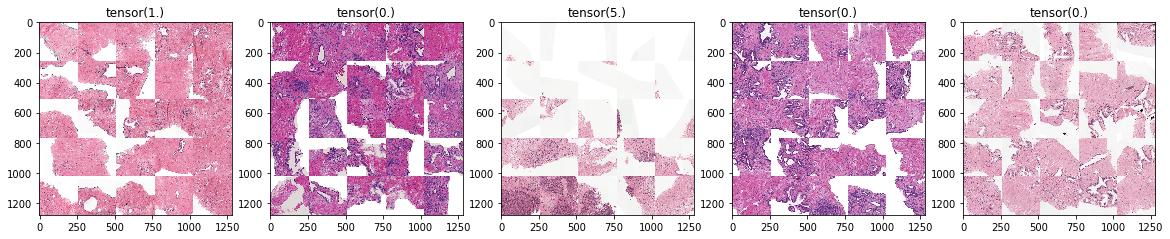

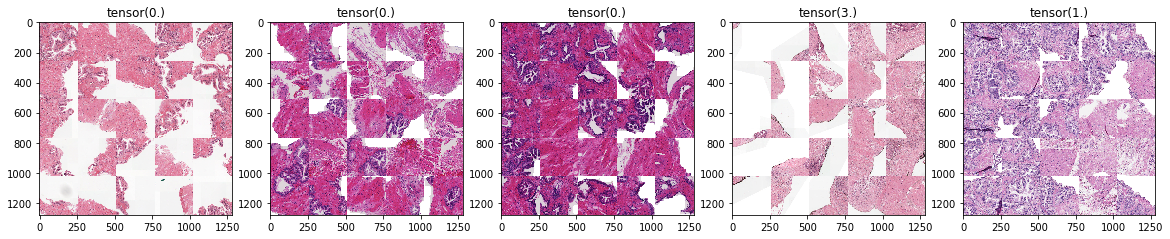

In [12]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))


# Loss

In [13]:
criterion = nn.BCEWithLogitsLoss()

# Train & Val

In [14]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            logits = model(data)
            loss = loss_func(logits, target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        
        scaler.update()
        0.889778
        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

    

# Create Dataloader & Model & Optimizer

In [15]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)


model = timm.create_model('ese_vovnet19b_dw', pretrained=True)

enet_type = model
model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

8493 2123


In [16]:
model.avg_pool = GeM()
model

enetv2(
  (enet): VovNet(
    (stem): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (act): ReLU(inplace=True)
        )
      )
      (1): SeparableConvBnAct(
        (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (conv_pw): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (act): ReLU(inplace=True)
        )
      )
      (2): SeparableConvBnAct(
        (conv_dw): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
        (conv_pw): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affi

# Run Training

In [ ]:
%%time

qwk_max = 0.
best_file = f'{kernel_type}_best_fold{fold}.pth'


scaler = GradScaler()

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    if(epoch>1):
        scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

Mon Jul 13 22:19:43 2020 Epoch: 1



qwk 0.7223945258340285 qwk_k 0.6661817666017856 qwk_r 0.6825332795482049
Mon Jul 13 22:32:51 2020 Epoch 1, lr: 0.0000300, train loss: 0.40107, val loss: 0.31678, acc: 43.00518, qwk: 0.72239
score2 (0.000000 --> 0.722395).  Saving model ...
Mon Jul 13 22:32:51 2020 Epoch: 2


/home/tonychenxyz/anaconda3/envs/torch1.6/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



qwk 0.5193396605943622 qwk_k 0.3667957644126357 qwk_r 0.5540184453227932
Mon Jul 13 22:46:03 2020 Epoch 2, lr: 0.0003000, train loss: 0.32413, val loss: 0.46011, acc: 34.24399, qwk: 0.51934
Mon Jul 13 22:46:03 2020 Epoch: 3



qwk 0.8269040570216595 qwk_k 0.8287135498002858 qwk_r 0.7846794639623326
Mon Jul 13 22:59:13 2020 Epoch 3, lr: 0.0000300, train loss: 0.24999, val loss: 0.24343, acc: 59.34998, qwk: 0.82690
score2 (0.722395 --> 0.826904).  Saving model ...
Mon Jul 13 22:59:14 2020 Epoch: 4



qwk 0.8359275431878179 qwk_k 0.8324701119752345 qwk_r 0.7929936305732483
Mon Jul 13 23:12:20 2020 Epoch 4, lr: 0.0002997, train loss: 0.26943, val loss: 0.25309, acc: 57.93688, qwk: 0.83593
score2 (0.826904 --> 0.835928).  Saving model ...
Mon Jul 13 23:12:20 2020 Epoch: 5



qwk 0.8246254403015917 qwk_k 0.8103586816490681 qwk_r 0.791374474053296
Mon Jul 13 23:25:26 2020 Epoch 5, lr: 0.0002993, train loss: 0.24626, val loss: 0.25016, acc: 60.85728, qwk: 0.82463
Mon Jul 13 23:25:26 2020 Epoch: 6



qwk 0.8201872998083322 qwk_k 0.8031538279000634 qwk_r 0.7877143857192859
Mon Jul 13 23:38:36 2020 Epoch 6, lr: 0.0002988, train loss: 0.23346, val loss: 0.26407, acc: 60.43335, qwk: 0.82019
Mon Jul 13 23:38:36 2020 Epoch: 7



qwk 0.8421342384717367 qwk_k 0.8406268518377829 qwk_r 0.8083255669462566
Mon Jul 13 23:51:47 2020 Epoch 7, lr: 0.0002981, train loss: 0.21810, val loss: 0.26238, acc: 64.06029, qwk: 0.84213
score2 (0.835928 --> 0.842134).  Saving model ...
Mon Jul 13 23:51:47 2020 Epoch: 8



qwk 0.8434287339726645 qwk_k 0.8471732803633223 qwk_r 0.806
Tue Jul 14 00:04:54 2020 Epoch 8, lr: 0.0002973, train loss: 0.20968, val loss: 0.22398, acc: 58.21950, qwk: 0.84343
score2 (0.842134 --> 0.843429).  Saving model ...
Tue Jul 14 00:04:54 2020 Epoch: 9



qwk 0.8621325768143371 qwk_k 0.8715957319256911 qwk_r 0.8247749249749916
Tue Jul 14 00:18:01 2020 Epoch 9, lr: 0.0002963, train loss: 0.19850, val loss: 0.21624, acc: 64.01319, qwk: 0.86213
score2 (0.843429 --> 0.862133).  Saving model ...
Tue Jul 14 00:18:01 2020 Epoch: 10



qwk 0.8543391498380382 qwk_k 0.8630457864053368 qwk_r 0.8081128747795414
Tue Jul 14 00:31:09 2020 Epoch 10, lr: 0.0002952, train loss: 0.19456, val loss: 0.21783, acc: 61.13990, qwk: 0.85434
Tue Jul 14 00:31:09 2020 Epoch: 11



qwk 0.8427696493813468 qwk_k 0.8378697824482907 qwk_r 0.8105807743658211
Tue Jul 14 00:44:15 2020 Epoch 11, lr: 0.0002939, train loss: 0.19177, val loss: 0.23000, acc: 65.04946, qwk: 0.84277
Tue Jul 14 00:44:15 2020 Epoch: 12



qwk 0.8706912207708881 qwk_k 0.8649692182340307 qwk_r 0.8447457627118644
Tue Jul 14 00:57:24 2020 Epoch 12, lr: 0.0002925, train loss: 0.18485, val loss: 0.21475, acc: 64.39001, qwk: 0.87069
score2 (0.862133 --> 0.870691).  Saving model ...
Tue Jul 14 00:57:24 2020 Epoch: 13



qwk 0.8639098271984962 qwk_k 0.8694630297900385 qwk_r 0.8247561385805584
Tue Jul 14 01:10:33 2020 Epoch 13, lr: 0.0002910, train loss: 0.17944, val loss: 0.21334, acc: 64.06029, qwk: 0.86391
Tue Jul 14 01:10:33 2020 Epoch: 14



qwk 0.8727744470203531 qwk_k 0.8777490529912437 qwk_r 0.836413748378729
Tue Jul 14 01:23:40 2020 Epoch 14, lr: 0.0002893, train loss: 0.17263, val loss: 0.21899, acc: 64.86105, qwk: 0.87277
score2 (0.870691 --> 0.872774).  Saving model ...
Tue Jul 14 01:23:40 2020 Epoch: 15



qwk 0.8753176739564521 qwk_k 0.8833161373757685 qwk_r 0.8410488831337002
Tue Jul 14 01:36:48 2020 Epoch 15, lr: 0.0002874, train loss: 0.16690, val loss: 0.20513, acc: 68.11116, qwk: 0.87532
score2 (0.872774 --> 0.875318).  Saving model ...
Tue Jul 14 01:36:48 2020 Epoch: 16



qwk 0.8617867660115255 qwk_k 0.8548661469340568 qwk_r 0.8354700854700855
Tue Jul 14 01:49:54 2020 Epoch 16, lr: 0.0002854, train loss: 0.15871, val loss: 0.22651, acc: 66.17993, qwk: 0.86179
Tue Jul 14 01:49:54 2020 Epoch: 17



qwk 0.8669720585216667 qwk_k 0.8541830036158258 qwk_r 0.8431023316062176
Tue Jul 14 02:03:02 2020 Epoch 17, lr: 0.0002833, train loss: 0.15665, val loss: 0.23323, acc: 66.93358, qwk: 0.86697
Tue Jul 14 02:03:02 2020 Epoch: 18



qwk 0.874886535372684 qwk_k 0.8788103741207127 qwk_r 0.842910574634478
Tue Jul 14 02:16:10 2020 Epoch 18, lr: 0.0002811, train loss: 0.15174, val loss: 0.21342, acc: 65.85021, qwk: 0.87489
Tue Jul 14 02:16:10 2020 Epoch: 19



qwk 0.8731291867289338 qwk_k 0.8800733045744952 qwk_r 0.8404255319148936
Tue Jul 14 02:29:19 2020 Epoch 19, lr: 0.0002787, train loss: 0.14522, val loss: 0.20958, acc: 67.92275, qwk: 0.87313
Tue Jul 14 02:29:19 2020 Epoch: 20



qwk 0.8675134531672553 qwk_k 0.87467905611933 qwk_r 0.8294117647058824
Tue Jul 14 02:42:30 2020 Epoch 20, lr: 0.0002762, train loss: 0.13969, val loss: 0.21847, acc: 67.49882, qwk: 0.86751
Tue Jul 14 02:42:30 2020 Epoch: 21



qwk 0.8640813702428324 qwk_k 0.8684273525311088 qwk_r 0.8294414641842853
Tue Jul 14 02:55:36 2020 Epoch 21, lr: 0.0002736, train loss: 0.13513, val loss: 0.25051, acc: 67.45172, qwk: 0.86408
Tue Jul 14 02:55:36 2020 Epoch: 22



qwk 0.8660113341719008 qwk_k 0.8708783953891768 qwk_r 0.8300663449939687
Tue Jul 14 03:08:42 2020 Epoch 22, lr: 0.0002708, train loss: 0.13270, val loss: 0.23764, acc: 66.41545, qwk: 0.86601
Tue Jul 14 03:08:42 2020 Epoch: 23



qwk 0.8786458087461554 qwk_k 0.8751274765437423 qwk_r 0.852076677316294
Tue Jul 14 03:21:49 2020 Epoch 23, lr: 0.0002679, train loss: 0.12633, val loss: 0.22583, acc: 67.54593, qwk: 0.87865
score2 (0.875318 --> 0.878646).  Saving model ...
Tue Jul 14 03:21:49 2020 Epoch: 24



qwk 0.847016408977413 qwk_k 0.8349139609656414 qwk_r 0.8243500317057705
Tue Jul 14 03:34:56 2020 Epoch 24, lr: 0.0002649, train loss: 0.12171, val loss: 0.27211, acc: 68.25247, qwk: 0.84702
Tue Jul 14 03:34:56 2020 Epoch: 25



qwk 0.8778644729617703 qwk_k 0.8582647116191897 qwk_r 0.8623141564318035
Tue Jul 14 03:48:03 2020 Epoch 25, lr: 0.0002618, train loss: 0.11568, val loss: 0.23927, acc: 70.60763, qwk: 0.87786
Tue Jul 14 03:48:03 2020 Epoch: 26



qwk 0.861843089413782 qwk_k 0.8529376902578907 qwk_r 0.8357761492338441
Tue Jul 14 04:01:09 2020 Epoch 26, lr: 0.0002586, train loss: 0.11481, val loss: 0.25269, acc: 69.00612, qwk: 0.86184
Tue Jul 14 04:01:09 2020 Epoch: 27



qwk 0.8723973947318945 qwk_k 0.8553427956961704 qwk_r 0.8553401046475839
Tue Jul 14 04:14:19 2020 Epoch 27, lr: 0.0002552, train loss: 0.10684, val loss: 0.26467, acc: 70.04239, qwk: 0.87240
Tue Jul 14 04:14:19 2020 Epoch: 28



qwk 0.8822089916063237 qwk_k 0.8789522422042743 qwk_r 0.8567362428842504
Tue Jul 14 04:27:26 2020 Epoch 28, lr: 0.0002518, train loss: 0.10686, val loss: 0.24025, acc: 67.92275, qwk: 0.88221
score2 (0.878646 --> 0.882209).  Saving model ...
Tue Jul 14 04:27:26 2020 Epoch: 29



qwk 0.8528288541316198 qwk_k 0.8460834871806382 qwk_r 0.8181233933161953
Tue Jul 14 04:40:33 2020 Epoch 29, lr: 0.0002482, train loss: 0.10089, val loss: 0.26983, acc: 69.14743, qwk: 0.85283
Tue Jul 14 04:40:33 2020 Epoch: 30



qwk 0.8851964183928467 qwk_k 0.8743788031766875 qwk_r 0.8653905526397037
Tue Jul 14 04:53:39 2020 Epoch 30, lr: 0.0002446, train loss: 0.09629, val loss: 0.23989, acc: 71.07866, qwk: 0.88520
score2 (0.882209 --> 0.885196).  Saving model ...
Tue Jul 14 04:53:39 2020 Epoch: 31



qwk 0.8651839468568308 qwk_k 0.8691032990225449 qwk_r 0.827761859280484
Tue Jul 14 05:06:48 2020 Epoch 31, lr: 0.0002408, train loss: 0.09411, val loss: 0.24205, acc: 69.75977, qwk: 0.86518
Tue Jul 14 05:06:48 2020 Epoch: 32



qwk 0.8695449798230019 qwk_k 0.8565062926998784 qwk_r 0.8463668947539915
Tue Jul 14 05:19:55 2020 Epoch 32, lr: 0.0002370, train loss: 0.08788, val loss: 0.24812, acc: 70.13660, qwk: 0.86954
Tue Jul 14 05:19:55 2020 Epoch: 33



qwk 0.8669625811550413 qwk_k 0.8429276429629424 qwk_r 0.8520149001015915
Tue Jul 14 05:32:59 2020 Epoch 33, lr: 0.0002331, train loss: 0.08556, val loss: 0.25336, acc: 69.43005, qwk: 0.86696
Tue Jul 14 05:32:59 2020 Epoch: 34



qwk 0.8871201711012584 qwk_k 0.8703977942799908 qwk_r 0.8770026702269693
Tue Jul 14 05:46:05 2020 Epoch 34, lr: 0.0002291, train loss: 0.08542, val loss: 0.24197, acc: 69.19454, qwk: 0.88712
score2 (0.885196 --> 0.887120).  Saving model ...
Tue Jul 14 05:46:05 2020 Epoch: 35



qwk 0.8857117819162684 qwk_k 0.8809328515373872 qwk_r 0.8645968790637191
Tue Jul 14 05:59:14 2020 Epoch 35, lr: 0.0002250, train loss: 0.07897, val loss: 0.25039, acc: 72.58596, qwk: 0.88571
Tue Jul 14 05:59:14 2020 Epoch: 36



qwk 0.880619875116757 qwk_k 0.8685956726621735 qwk_r 0.8616783663050415
Tue Jul 14 06:12:21 2020 Epoch 36, lr: 0.0002208, train loss: 0.07345, val loss: 0.26304, acc: 71.36128, qwk: 0.88062
Tue Jul 14 06:12:21 2020 Epoch: 37



qwk 0.8830937441152799 qwk_k 0.8724955645168045 qwk_r 0.8626089764288021
Tue Jul 14 06:25:29 2020 Epoch 37, lr: 0.0002166, train loss: 0.06908, val loss: 0.26144, acc: 72.20914, qwk: 0.88309
Tue Jul 14 06:25:29 2020 Epoch: 38



qwk 0.8901577726781053 qwk_k 0.8784036231824572 qwk_r 0.874572583152005
Tue Jul 14 06:38:38 2020 Epoch 38, lr: 0.0002123, train loss: 0.06737, val loss: 0.26304, acc: 72.96279, qwk: 0.89016
score2 (0.887120 --> 0.890158).  Saving model ...
Tue Jul 14 06:38:38 2020 Epoch: 39



qwk 0.8964743977788767 qwk_k 0.8914200609369183 qwk_r 0.8771069567882317
Tue Jul 14 06:51:47 2020 Epoch 39, lr: 0.0002080, train loss: 0.06661, val loss: 0.25279, acc: 73.71644, qwk: 0.89647
score2 (0.890158 --> 0.896474).  Saving model ...
Tue Jul 14 06:51:47 2020 Epoch: 40



qwk 0.8880974182409169 qwk_k 0.8721179102336707 qwk_r 0.8724739742804655
Tue Jul 14 07:04:54 2020 Epoch 40, lr: 0.0002035, train loss: 0.06272, val loss: 0.25970, acc: 72.25624, qwk: 0.88810
Tue Jul 14 07:04:54 2020 Epoch: 41



qwk 0.8917108003075345 qwk_k 0.8850007712575906 qwk_r 0.8712307692307693
Tue Jul 14 07:18:01 2020 Epoch 41, lr: 0.0001991, train loss: 0.05820, val loss: 0.26491, acc: 73.48092, qwk: 0.89171
Tue Jul 14 07:18:01 2020 Epoch: 42



qwk 0.8880615039558505 qwk_k 0.8781745507101799 qwk_r 0.8712426402231175
Tue Jul 14 07:31:07 2020 Epoch 42, lr: 0.0001945, train loss: 0.05419, val loss: 0.28134, acc: 73.52803, qwk: 0.88806
Tue Jul 14 07:31:07 2020 Epoch: 43



qwk 0.8830939653010191 qwk_k 0.8790365128502481 qwk_r 0.8574969021065675
Tue Jul 14 07:44:15 2020 Epoch 43, lr: 0.0001900, train loss: 0.05109, val loss: 0.30880, acc: 70.60763, qwk: 0.88309
Tue Jul 14 07:44:15 2020 Epoch: 44



qwk 0.8866960378146598 qwk_k 0.8841751105966825 qwk_r 0.8656101426307449
Tue Jul 14 07:57:27 2020 Epoch 44, lr: 0.0001854, train loss: 0.04953, val loss: 0.27971, acc: 71.78521, qwk: 0.88670
Tue Jul 14 07:57:27 2020 Epoch: 45



qwk 0.8941778301538418 qwk_k 0.8696772701059411 qwk_r 0.8849886768036235
Tue Jul 14 08:10:34 2020 Epoch 45, lr: 0.0001807, train loss: 0.04889, val loss: 0.26449, acc: 72.30334, qwk: 0.89418
Tue Jul 14 08:10:34 2020 Epoch: 46



qwk 0.8942577594618014 qwk_k 0.8802648527751074 qwk_r 0.8811659192825112
Tue Jul 14 08:23:43 2020 Epoch 46, lr: 0.0001760, train loss: 0.04525, val loss: 0.26762, acc: 72.68017, qwk: 0.89426
Tue Jul 14 08:23:43 2020 Epoch: 47



qwk 0.8845579553927027 qwk_k 0.8834417840672184 qwk_r 0.8596228674049686
Tue Jul 14 08:36:53 2020 Epoch 47, lr: 0.0001713, train loss: 0.04493, val loss: 0.32171, acc: 72.68017, qwk: 0.88456
Tue Jul 14 08:36:53 2020 Epoch: 48



qwk 0.8943786727536062 qwk_k 0.8797654431242197 qwk_r 0.8817153628652215
Tue Jul 14 08:50:00 2020 Epoch 48, lr: 0.0001666, train loss: 0.04061, val loss: 0.29593, acc: 73.85775, qwk: 0.89438
Tue Jul 14 08:50:00 2020 Epoch: 49



qwk 0.896314282580551 qwk_k 0.8808496296069331 qwk_r 0.8835830212234707
Tue Jul 14 09:03:09 2020 Epoch 49, lr: 0.0001619, train loss: 0.03634, val loss: 0.28118, acc: 74.09326, qwk: 0.89631
Tue Jul 14 09:03:09 2020 Epoch: 50



qwk 0.8871615713423758 qwk_k 0.8725148728435079 qwk_r 0.873164636051234
Tue Jul 14 09:16:18 2020 Epoch 50, lr: 0.0001571, train loss: 0.03696, val loss: 0.29922, acc: 73.52803, qwk: 0.88716
Tue Jul 14 09:16:18 2020 Epoch: 51



qwk 0.8944093423633875 qwk_k 0.8740846127255474 qwk_r 0.8850825288072252
Tue Jul 14 09:29:27 2020 Epoch 51, lr: 0.0001524, train loss: 0.03196, val loss: 0.29800, acc: 74.47009, qwk: 0.89441
Tue Jul 14 09:29:27 2020 Epoch: 52



qwk 0.8979224125555451 qwk_k 0.8711228735547157 qwk_r 0.8916379580331977
Tue Jul 14 09:42:38 2020 Epoch 52, lr: 0.0001476, train loss: 0.03429, val loss: 0.30240, acc: 75.17664, qwk: 0.89792
score2 (0.896474 --> 0.897922).  Saving model ...
Tue Jul 14 09:42:38 2020 Epoch: 53



qwk 0.9005547261016318 qwk_k 0.8800334194044444 qwk_r 0.8926544766708702
Tue Jul 14 09:55:50 2020 Epoch 53, lr: 0.0001429, train loss: 0.03117, val loss: 0.28057, acc: 75.74187, qwk: 0.90055
score2 (0.897922 --> 0.900555).  Saving model ...
Tue Jul 14 09:55:50 2020 Epoch: 54



qwk 0.8927663604916092 qwk_k 0.8813217765269645 qwk_r 0.8782986650108662
Tue Jul 14 10:09:01 2020 Epoch 54, lr: 0.0001381, train loss: 0.02743, val loss: 0.30327, acc: 74.51719, qwk: 0.89277
Tue Jul 14 10:09:01 2020 Epoch: 55



qwk 0.8980491016211493 qwk_k 0.8810843342633273 qwk_r 0.8877551020408163
Tue Jul 14 10:22:11 2020 Epoch 55, lr: 0.0001334, train loss: 0.02719, val loss: 0.31242, acc: 75.50636, qwk: 0.89805
Tue Jul 14 10:22:11 2020 Epoch: 56



qwk 0.9049206008840462 qwk_k 0.8845385226215492 qwk_r 0.8981942714819428
Tue Jul 14 10:35:21 2020 Epoch 56, lr: 0.0001287, train loss: 0.02388, val loss: 0.28911, acc: 76.82525, qwk: 0.90492
score2 (0.900555 --> 0.904921).  Saving model ...
Tue Jul 14 10:35:21 2020 Epoch: 57



qwk 0.9020160665548481 qwk_k 0.884052254834599 qwk_r 0.8934326543022195
Tue Jul 14 10:48:38 2020 Epoch 57, lr: 0.0001240, train loss: 0.02251, val loss: 0.31148, acc: 74.89402, qwk: 0.90202
Tue Jul 14 10:48:38 2020 Epoch: 58



qwk 0.9011768114381621 qwk_k 0.8752401974065054 qwk_r 0.8969573400250941
Tue Jul 14 11:01:49 2020 Epoch 58, lr: 0.0001193, train loss: 0.02300, val loss: 0.30263, acc: 75.60057, qwk: 0.90118
Tue Jul 14 11:01:49 2020 Epoch: 59



qwk 0.9028182627695271 qwk_k 0.8846533710120131 qwk_r 0.8941085271317829
Tue Jul 14 11:15:01 2020 Epoch 59, lr: 0.0001146, train loss: 0.02039, val loss: 0.30583, acc: 76.58973, qwk: 0.90282
Tue Jul 14 11:15:01 2020 Epoch: 60



qwk 0.8971787829740049 qwk_k 0.8835770351232064 qwk_r 0.8830253679924835
Tue Jul 14 11:28:14 2020 Epoch 60, lr: 0.0001100, train loss: 0.01930, val loss: 0.33109, acc: 75.74187, qwk: 0.89718
Tue Jul 14 11:28:14 2020 Epoch: 61



qwk 0.8958371118147905 qwk_k 0.8780065156606726 qwk_r 0.8854426433915212
Tue Jul 14 11:41:23 2020 Epoch 61, lr: 0.0001055, train loss: 0.01825, val loss: 0.35654, acc: 75.22374, qwk: 0.89584
Tue Jul 14 11:41:23 2020 Epoch: 62



qwk 0.8995592897235323 qwk_k 0.8763401624712095 qwk_r 0.892933618843683
Tue Jul 14 11:54:34 2020 Epoch 62, lr: 0.0001009, train loss: 0.01723, val loss: 0.35400, acc: 75.60057, qwk: 0.89956
Tue Jul 14 11:54:34 2020 Epoch: 63



qwk 0.9036733908350755 qwk_k 0.8869834245699422 qwk_r 0.8945979509469109
Tue Jul 14 12:07:43 2020 Epoch 63, lr: 0.0000965, train loss: 0.01673, val loss: 0.33187, acc: 76.49553, qwk: 0.90367
Tue Jul 14 12:07:43 2020 Epoch: 64



qwk 0.901611334836677 qwk_k 0.8877335696427123 qwk_r 0.8902701043585022
Tue Jul 14 12:20:52 2020 Epoch 64, lr: 0.0000920, train loss: 0.01501, val loss: 0.32633, acc: 76.40132, qwk: 0.90161
Tue Jul 14 12:20:52 2020 Epoch: 65



qwk 0.8965095147244136 qwk_k 0.8708258177440494 qwk_r 0.8909959913660191
Tue Jul 14 12:34:05 2020 Epoch 65, lr: 0.0000877, train loss: 0.01409, val loss: 0.35076, acc: 76.58973, qwk: 0.89651
Tue Jul 14 12:34:05 2020 Epoch: 66



qwk 0.9055615620861993 qwk_k 0.8813198067845032 qwk_r 0.9018366054464851
Tue Jul 14 12:47:14 2020 Epoch 66, lr: 0.0000834, train loss: 0.01231, val loss: 0.32745, acc: 76.58973, qwk: 0.90556
score2 (0.904921 --> 0.905562).  Saving model ...
Tue Jul 14 12:47:14 2020 Epoch: 67



qwk 0.9075567045452394 qwk_k 0.8890754480561527 qwk_r 0.8992058643860721
Tue Jul 14 13:00:24 2020 Epoch 67, lr: 0.0000792, train loss: 0.01199, val loss: 0.34189, acc: 76.49553, qwk: 0.90756
score2 (0.905562 --> 0.907557).  Saving model ...
Tue Jul 14 13:00:24 2020 Epoch: 68



qwk 0.904385992440808 qwk_k 0.8826466883830636 qwk_r 0.8989123480486244
Tue Jul 14 13:13:33 2020 Epoch 68, lr: 0.0000750, train loss: 0.01183, val loss: 0.33244, acc: 76.44842, qwk: 0.90439
Tue Jul 14 13:13:33 2020 Epoch: 69



qwk 0.9061891356305921 qwk_k 0.8770445187929325 qwk_r 0.9047470331043098
Tue Jul 14 13:26:41 2020 Epoch 69, lr: 0.0000709, train loss: 0.01154, val loss: 0.32482, acc: 76.96656, qwk: 0.90619
Tue Jul 14 13:26:41 2020 Epoch: 70



qwk 0.9057397114477143 qwk_k 0.8835510872725639 qwk_r 0.8999078906969604
Tue Jul 14 13:39:52 2020 Epoch 70, lr: 0.0000669, train loss: 0.00997, val loss: 0.35995, acc: 77.20207, qwk: 0.90574
Tue Jul 14 13:39:52 2020 Epoch: 71



qwk 0.9053064823494767 qwk_k 0.886034138597677 qwk_r 0.8988833746898263
Tue Jul 14 13:53:03 2020 Epoch 71, lr: 0.0000630, train loss: 0.00989, val loss: 0.34192, acc: 77.72021, qwk: 0.90531
Tue Jul 14 13:53:03 2020 Epoch: 72



qwk 0.9093661804717929 qwk_k 0.8909075858154238 qwk_r 0.9012578616352201
Tue Jul 14 14:06:11 2020 Epoch 72, lr: 0.0000592, train loss: 0.00901, val loss: 0.34228, acc: 76.44842, qwk: 0.90937
score2 (0.907557 --> 0.909366).  Saving model ...
Tue Jul 14 14:06:11 2020 Epoch: 73



qwk 0.904727158836401 qwk_k 0.8893523239599663 qwk_r 0.8932879678317353
Tue Jul 14 14:19:20 2020 Epoch 73, lr: 0.0000554, train loss: 0.00799, val loss: 0.34699, acc: 77.06076, qwk: 0.90473
Tue Jul 14 14:19:20 2020 Epoch: 74



qwk 0.9112367692261879 qwk_k 0.8906589014835078 qwk_r 0.9061332503113325
Tue Jul 14 14:32:30 2020 Epoch 74, lr: 0.0000518, train loss: 0.00749, val loss: 0.33949, acc: 78.14414, qwk: 0.91124
score2 (0.909366 --> 0.911237).  Saving model ...
Tue Jul 14 14:32:30 2020 Epoch: 75



qwk 0.9047714057080258 qwk_k 0.8860422009953279 qwk_r 0.8960567823343849
Tue Jul 14 14:45:38 2020 Epoch 75, lr: 0.0000482, train loss: 0.00663, val loss: 0.36952, acc: 77.15497, qwk: 0.90477
Tue Jul 14 14:45:38 2020 Epoch: 76



qwk 0.9110176066730261 qwk_k 0.8884570222283854 qwk_r 0.9064254522769807
Tue Jul 14 14:58:50 2020 Epoch 76, lr: 0.0000448, train loss: 0.00642, val loss: 0.36874, acc: 78.70937, qwk: 0.91102
Tue Jul 14 14:58:50 2020 Epoch: 77



qwk 0.9070862431563121 qwk_k 0.8858888734399946 qwk_r 0.8999382334774553
Tue Jul 14 15:11:59 2020 Epoch 77, lr: 0.0000414, train loss: 0.00553, val loss: 0.35847, acc: 78.52096, qwk: 0.90709
Tue Jul 14 15:11:59 2020 Epoch: 78



qwk 0.9060140476055376 qwk_k 0.8795981873763951 qwk_r 0.9026117054751416
Tue Jul 14 15:25:09 2020 Epoch 78, lr: 0.0000382, train loss: 0.00637, val loss: 0.34488, acc: 77.10787, qwk: 0.90601
Tue Jul 14 15:25:09 2020 Epoch: 79



qwk 0.9071910245871354 qwk_k 0.8838077355148777 qwk_r 0.9030265596046942
Tue Jul 14 15:38:18 2020 Epoch 79, lr: 0.0000351, train loss: 0.00490, val loss: 0.35710, acc: 77.53179, qwk: 0.90719
Tue Jul 14 15:38:18 2020 Epoch: 80



qwk 0.911029586008348 qwk_k 0.8904349750906987 qwk_r 0.9060068471833178
Tue Jul 14 15:51:28 2020 Epoch 80, lr: 0.0000321, train loss: 0.00442, val loss: 0.35122, acc: 78.56806, qwk: 0.91103
Tue Jul 14 15:51:28 2020 Epoch: 81



qwk 0.9119570830225486 qwk_k 0.8920939887676373 qwk_r 0.9053763440860215
Tue Jul 14 16:04:36 2020 Epoch 81, lr: 0.0000292, train loss: 0.00494, val loss: 0.36086, acc: 78.37965, qwk: 0.91196
score2 (0.911237 --> 0.911957).  Saving model ...
Tue Jul 14 16:04:36 2020 Epoch: 82



qwk 0.9137576995828428 qwk_k 0.8912364525654454 qwk_r 0.910068578553616
Tue Jul 14 16:17:47 2020 Epoch 82, lr: 0.0000264, train loss: 0.00384, val loss: 0.35058, acc: 78.04993, qwk: 0.91376
score2 (0.911957 --> 0.913758).  Saving model ...
Tue Jul 14 16:17:47 2020 Epoch: 83



qwk 0.9070391014878004 qwk_k 0.8824131833552461 qwk_r 0.9033468877072255
Tue Jul 14 16:30:58 2020 Epoch 83, lr: 0.0000238, train loss: 0.00326, val loss: 0.37295, acc: 78.33255, qwk: 0.90704
Tue Jul 14 16:30:58 2020 Epoch: 84
